# Twitter Sentiment Analysis

Importing necessary packages

In [1]:
# Packages
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt

#plotly
import plotly.express as px

#seaborn
import seaborn as sns

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yoges\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Initialisation

In [3]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 1
BATCH_SIZE = 8192

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"

# EXPORT
KERAS_MODEL = "keras_model.h5"
WORD2VEC_MODEL = "word2vec_model.w2v"
TOKENIZER_MODEL = "tokenizer_model.pkl"
ENCODER_MODEL = "encoder_model.pkl"

Reading Input Dataset

In [4]:
df = pd.read_csv("training.1600000.processed.noemoticon.csv", encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

In [5]:
print("Dataset size:", len(df))
df.head(5)

Dataset size: 1600000


,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


Mapping target label to string

In [6]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [7]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

Wall time: 523 ms


Text(0.5, 1.0, 'Dataset labels distribuition')

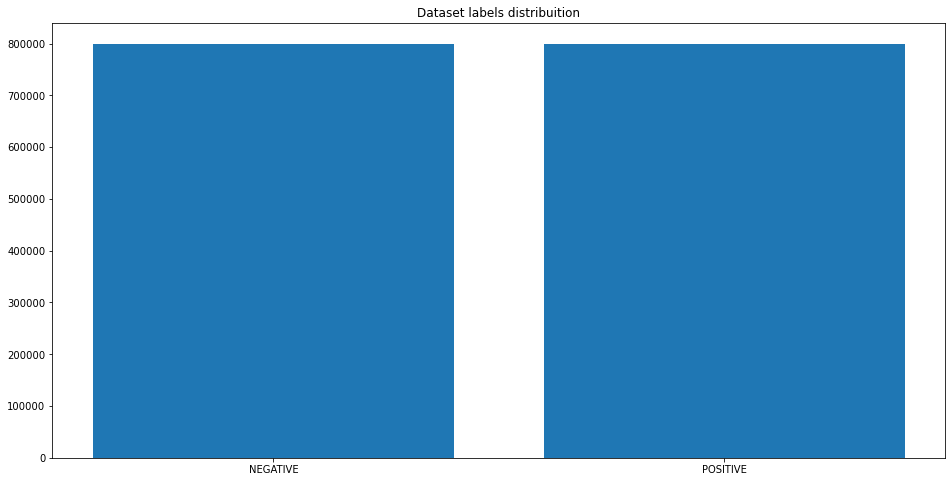

In [8]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")


Pre-processing the Dataset

In [9]:
#pre-process dataset
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [10]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)


In [11]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

Wall time: 1min 4s


Split and Train Dataset

In [12]:
#Split and train dataset
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1280000
TEST size: 320000


WORD2VEC

In [13]:
%%time
documents = [_text.split() for _text in df_train.text] 

Wall time: 4.75 s


In [14]:
#Word2Vec
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [15]:
w2v_model.build_vocab(documents)

2020-08-14 20:59:28,454 : INFO : collecting all words and their counts
2020-08-14 20:59:28,455 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-08-14 20:59:28,492 : INFO : PROGRESS: at sentence #10000, processed 72565 words, keeping 14005 word types
2020-08-14 20:59:28,528 : INFO : PROGRESS: at sentence #20000, processed 144393 words, keeping 21587 word types
2020-08-14 20:59:28,571 : INFO : PROGRESS: at sentence #30000, processed 215826 words, keeping 27541 word types
2020-08-14 20:59:28,611 : INFO : PROGRESS: at sentence #40000, processed 288271 words, keeping 32764 word types
2020-08-14 20:59:28,652 : INFO : PROGRESS: at sentence #50000, processed 359772 words, keeping 37587 word types
2020-08-14 20:59:28,701 : INFO : PROGRESS: at sentence #60000, processed 431431 words, keeping 42198 word types
2020-08-14 20:59:28,748 : INFO : PROGRESS: at sentence #70000, processed 503103 words, keeping 46458 word types
2020-08-14 20:59:28,787 : INFO : PROGRESS: at s

2020-08-14 20:59:31,865 : INFO : PROGRESS: at sentence #720000, processed 5193881 words, keeping 200325 word types
2020-08-14 20:59:31,897 : INFO : PROGRESS: at sentence #730000, processed 5265467 words, keeping 202133 word types
2020-08-14 20:59:31,935 : INFO : PROGRESS: at sentence #740000, processed 5337518 words, keeping 203818 word types
2020-08-14 20:59:31,986 : INFO : PROGRESS: at sentence #750000, processed 5409321 words, keeping 205535 word types
2020-08-14 20:59:32,038 : INFO : PROGRESS: at sentence #760000, processed 5481512 words, keeping 207282 word types
2020-08-14 20:59:32,089 : INFO : PROGRESS: at sentence #770000, processed 5554093 words, keeping 209076 word types
2020-08-14 20:59:32,135 : INFO : PROGRESS: at sentence #780000, processed 5625382 words, keeping 210805 word types
2020-08-14 20:59:32,177 : INFO : PROGRESS: at sentence #790000, processed 5698066 words, keeping 212618 word types
2020-08-14 20:59:32,212 : INFO : PROGRESS: at sentence #800000, processed 577088

In [16]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 30369


In [17]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2020-08-14 20:59:48,482 : INFO : training model with 8 workers on 30369 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
2020-08-14 20:59:49,515 : INFO : EPOCH 1 - PROGRESS: at 6.08% examples, 493971 words/s, in_qsize 16, out_qsize 0
2020-08-14 20:59:50,519 : INFO : EPOCH 1 - PROGRESS: at 13.47% examples, 548186 words/s, in_qsize 15, out_qsize 0
2020-08-14 20:59:51,528 : INFO : EPOCH 1 - PROGRESS: at 20.59% examples, 559442 words/s, in_qsize 15, out_qsize 1
2020-08-14 20:59:52,569 : INFO : EPOCH 1 - PROGRESS: at 27.75% examples, 560955 words/s, in_qsize 16, out_qsize 0
2020-08-14 20:59:53,610 : INFO : EPOCH 1 - PROGRESS: at 34.89% examples, 561962 words/s, in_qsize 16, out_qsize 1
2020-08-14 20:59:54,619 : INFO : EPOCH 1 - PROGRESS: at 42.13% examples, 566740 words/s, in_qsize 15, out_qsize 0
2020-08-14 20:59:55,631 : INFO : EPOCH 1 - PROGRESS: at 49.49% examples, 571201 words/s, in_qsize 15, out_qsize 0
2020-08-14 20:59:56,675 : INFO : EPOCH 1 - PROGRESS: 

2020-08-14 21:00:38,893 : INFO : EPOCH 4 - PROGRESS: at 37.05% examples, 500808 words/s, in_qsize 15, out_qsize 0
2020-08-14 21:00:39,919 : INFO : EPOCH 4 - PROGRESS: at 44.07% examples, 510155 words/s, in_qsize 15, out_qsize 3
2020-08-14 21:00:40,922 : INFO : EPOCH 4 - PROGRESS: at 51.43% examples, 521735 words/s, in_qsize 14, out_qsize 1
2020-08-14 21:00:41,958 : INFO : EPOCH 4 - PROGRESS: at 58.58% examples, 526840 words/s, in_qsize 15, out_qsize 0
2020-08-14 21:00:42,991 : INFO : EPOCH 4 - PROGRESS: at 65.93% examples, 532872 words/s, in_qsize 15, out_qsize 0
2020-08-14 21:00:44,004 : INFO : EPOCH 4 - PROGRESS: at 72.32% examples, 531633 words/s, in_qsize 16, out_qsize 1
2020-08-14 21:00:45,019 : INFO : EPOCH 4 - PROGRESS: at 78.62% examples, 529779 words/s, in_qsize 16, out_qsize 0
2020-08-14 21:00:46,020 : INFO : EPOCH 4 - PROGRESS: at 84.80% examples, 527953 words/s, in_qsize 15, out_qsize 0
2020-08-14 21:00:47,024 : INFO : EPOCH 4 - PROGRESS: at 91.09% examples, 527078 words/s,

2020-08-14 21:01:31,571 : INFO : EPOCH 7 - PROGRESS: at 98.47% examples, 564350 words/s, in_qsize 15, out_qsize 0
2020-08-14 21:01:31,694 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-08-14 21:01:31,707 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-08-14 21:01:31,715 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-08-14 21:01:31,721 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-08-14 21:01:31,763 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-08-14 21:01:31,773 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-08-14 21:01:31,778 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-08-14 21:01:31,779 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-08-14 21:01:31,779 : INFO : EPOCH - 7 : training on 9227204 raw words (8222922 effective words) took 14.6s, 564953 effective words/s
2020-08-14 21:01:32,

2020-08-14 21:02:16,675 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-08-14 21:02:16,675 : INFO : EPOCH - 10 : training on 9227204 raw words (8222971 effective words) took 14.5s, 567061 effective words/s
2020-08-14 21:02:17,746 : INFO : EPOCH 11 - PROGRESS: at 6.18% examples, 484474 words/s, in_qsize 16, out_qsize 0
2020-08-14 21:02:18,757 : INFO : EPOCH 11 - PROGRESS: at 13.79% examples, 549380 words/s, in_qsize 16, out_qsize 0
2020-08-14 21:02:19,775 : INFO : EPOCH 11 - PROGRESS: at 20.59% examples, 550166 words/s, in_qsize 16, out_qsize 0
2020-08-14 21:02:20,783 : INFO : EPOCH 11 - PROGRESS: at 27.64% examples, 556200 words/s, in_qsize 16, out_qsize 0
2020-08-14 21:02:21,785 : INFO : EPOCH 11 - PROGRESS: at 34.89% examples, 563572 words/s, in_qsize 16, out_qsize 0
2020-08-14 21:02:22,807 : INFO : EPOCH 11 - PROGRESS: at 42.24% examples, 568564 words/s, in_qsize 16, out_qsize 0
2020-08-14 21:02:23,811 : INFO : EPOCH 11 - PROGRESS: at 49.38% examples, 570908 

2020-08-14 21:03:07,462 : INFO : EPOCH 14 - PROGRESS: at 56.51% examples, 569492 words/s, in_qsize 14, out_qsize 1
2020-08-14 21:03:08,465 : INFO : EPOCH 14 - PROGRESS: at 64.19% examples, 576046 words/s, in_qsize 15, out_qsize 0
2020-08-14 21:03:09,489 : INFO : EPOCH 14 - PROGRESS: at 71.35% examples, 575835 words/s, in_qsize 15, out_qsize 0
2020-08-14 21:03:10,504 : INFO : EPOCH 14 - PROGRESS: at 78.62% examples, 576939 words/s, in_qsize 14, out_qsize 1
2020-08-14 21:03:11,540 : INFO : EPOCH 14 - PROGRESS: at 85.77% examples, 576171 words/s, in_qsize 15, out_qsize 0
2020-08-14 21:03:12,539 : INFO : EPOCH 14 - PROGRESS: at 92.28% examples, 572920 words/s, in_qsize 12, out_qsize 1
2020-08-14 21:03:13,469 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-08-14 21:03:13,497 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-08-14 21:03:13,500 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-08-14 21:03:13,518 : INFO : work

2020-08-14 21:03:56,293 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-08-14 21:03:56,316 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-08-14 21:03:56,321 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-08-14 21:03:56,327 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-08-14 21:03:56,329 : INFO : EPOCH - 17 : training on 9227204 raw words (8222637 effective words) took 14.2s, 580390 effective words/s
2020-08-14 21:03:57,362 : INFO : EPOCH 18 - PROGRESS: at 5.97% examples, 485053 words/s, in_qsize 12, out_qsize 3
2020-08-14 21:03:58,367 : INFO : EPOCH 18 - PROGRESS: at 12.06% examples, 491405 words/s, in_qsize 14, out_qsize 3
2020-08-14 21:03:59,369 : INFO : EPOCH 18 - PROGRESS: at 19.62% examples, 534303 words/s, in_qsize 14, out_qsize 1
2020-08-14 21:04:00,375 : INFO : EPOCH 18 - PROGRESS: at 25.80% examples, 527161 words/s, in_qsize 15, out_qsize 1
2020-08-14 21:04:01,394 : INFO : EPOCH

2020-08-14 21:04:44,483 : INFO : EPOCH 21 - PROGRESS: at 33.92% examples, 552449 words/s, in_qsize 13, out_qsize 1
2020-08-14 21:04:45,492 : INFO : EPOCH 21 - PROGRESS: at 41.48% examples, 563506 words/s, in_qsize 15, out_qsize 0
2020-08-14 21:04:46,496 : INFO : EPOCH 21 - PROGRESS: at 48.51% examples, 565465 words/s, in_qsize 16, out_qsize 1
2020-08-14 21:04:47,535 : INFO : EPOCH 21 - PROGRESS: at 55.42% examples, 563175 words/s, in_qsize 16, out_qsize 0
2020-08-14 21:04:48,554 : INFO : EPOCH 21 - PROGRESS: at 62.79% examples, 566853 words/s, in_qsize 15, out_qsize 0
2020-08-14 21:04:49,571 : INFO : EPOCH 21 - PROGRESS: at 69.94% examples, 567919 words/s, in_qsize 15, out_qsize 1
2020-08-14 21:04:50,588 : INFO : EPOCH 21 - PROGRESS: at 77.42% examples, 571247 words/s, in_qsize 15, out_qsize 0
2020-08-14 21:04:51,602 : INFO : EPOCH 21 - PROGRESS: at 84.59% examples, 571943 words/s, in_qsize 16, out_qsize 0
2020-08-14 21:04:52,617 : INFO : EPOCH 21 - PROGRESS: at 91.74% examples, 572415

2020-08-14 21:05:35,422 : INFO : EPOCH 24 - PROGRESS: at 93.37% examples, 575890 words/s, in_qsize 14, out_qsize 1
2020-08-14 21:05:36,199 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-08-14 21:05:36,207 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-08-14 21:05:36,210 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-08-14 21:05:36,231 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-08-14 21:05:36,235 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-08-14 21:05:36,245 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-08-14 21:05:36,265 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-08-14 21:05:36,268 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-08-14 21:05:36,272 : INFO : EPOCH - 24 : training on 9227204 raw words (8222717 effective words) took 14.2s, 579872 effective words/s
2020-08-14 21:05:3

2020-08-14 21:06:19,604 : INFO : EPOCH - 27 : training on 9227204 raw words (8223023 effective words) took 14.4s, 572645 effective words/s
2020-08-14 21:06:20,645 : INFO : EPOCH 28 - PROGRESS: at 5.97% examples, 479130 words/s, in_qsize 14, out_qsize 1
2020-08-14 21:06:21,687 : INFO : EPOCH 28 - PROGRESS: at 12.71% examples, 504279 words/s, in_qsize 15, out_qsize 0
2020-08-14 21:06:22,691 : INFO : EPOCH 28 - PROGRESS: at 19.84% examples, 531398 words/s, in_qsize 14, out_qsize 1
2020-08-14 21:06:23,712 : INFO : EPOCH 28 - PROGRESS: at 26.78% examples, 537793 words/s, in_qsize 16, out_qsize 0
2020-08-14 21:06:24,731 : INFO : EPOCH 28 - PROGRESS: at 34.03% examples, 547483 words/s, in_qsize 14, out_qsize 1
2020-08-14 21:06:25,745 : INFO : EPOCH 28 - PROGRESS: at 41.48% examples, 557068 words/s, in_qsize 14, out_qsize 1
2020-08-14 21:06:26,758 : INFO : EPOCH 28 - PROGRESS: at 48.51% examples, 559302 words/s, in_qsize 15, out_qsize 1
2020-08-14 21:06:27,781 : INFO : EPOCH 28 - PROGRESS: at 

2020-08-14 21:07:10,877 : INFO : EPOCH 31 - PROGRESS: at 54.03% examples, 545791 words/s, in_qsize 15, out_qsize 2
2020-08-14 21:07:11,904 : INFO : EPOCH 31 - PROGRESS: at 61.71% examples, 553742 words/s, in_qsize 15, out_qsize 0
2020-08-14 21:07:12,949 : INFO : EPOCH 31 - PROGRESS: at 69.07% examples, 556456 words/s, in_qsize 16, out_qsize 1
2020-08-14 21:07:13,977 : INFO : EPOCH 31 - PROGRESS: at 76.55% examples, 560215 words/s, in_qsize 15, out_qsize 0
2020-08-14 21:07:14,995 : INFO : EPOCH 31 - PROGRESS: at 84.05% examples, 563825 words/s, in_qsize 15, out_qsize 0
2020-08-14 21:07:15,996 : INFO : EPOCH 31 - PROGRESS: at 91.20% examples, 565480 words/s, in_qsize 15, out_qsize 0
2020-08-14 21:07:17,030 : INFO : EPOCH 31 - PROGRESS: at 99.01% examples, 569413 words/s, in_qsize 10, out_qsize 0
2020-08-14 21:07:17,069 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-08-14 21:07:17,073 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-08-14 21

Wall time: 7min 42s


(263124962, 295270528)

In [18]:
w2v_model.most_similar("great")

c:\users\yoges\pycharmprojects\tweetsenti\venv\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
2020-08-14 21:07:31,340 : INFO : precomputing L2-norms of word weight vectors


[('fantastic', 0.7283889651298523),
 ('wonderful', 0.6922730803489685),
 ('good', 0.6920604705810547),
 ('awesome', 0.6836432218551636),
 ('amazing', 0.642839789390564),
 ('fabulous', 0.6038628816604614),
 ('excellent', 0.59214186668396),
 ('fab', 0.5837719440460205),
 ('nice', 0.5666813850402832),
 ('gr8', 0.5599476099014282)]

Tokenize Text

In [19]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 290419
Wall time: 33.1 s


In [20]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

Wall time: 49.7 s


Label Encoder

In [21]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [22]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1280000, 1)
y_test (320000, 1)


In [23]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1280000, 300)
y_train (1280000, 1)

x_test (320000, 300)
y_test (320000, 1)


In [24]:
y_train[:10]

array([[1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]], dtype=int64)

Embedding Layer

In [25]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(290419, 300)


In [26]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

Build Model

In [27]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          87125700  
_________________________________________________________________
dropout (Dropout)            (None, 300, 300)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 87,286,201
Trainable params: 160,501
Non-trainable params: 87,125,700
_________________________________________________________________


Compile Model

In [28]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

Callbacks

In [29]:
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

Training

In [33]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

141/141 [==============================] - ETA: 0s - loss: 0.5328 - accuracy: 0.7290  WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2020-08-15 03:35:35,721 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


141/141 [==============================] - 22388s 159s/step - loss: 0.5328 - accuracy: 0.7290 - val_loss: 0.4797 - val_accuracy: 0.7719
Wall time: 6h 15min 24s


Evaluate

In [34]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

40/40 [==============================] - 520s 13s/step - loss: 0.4779 - accuracy: 0.7730

ACCURACY: 0.7729718685150146
LOSS: 0.4779494106769562
Wall time: 8min 53s


Predictions

In [41]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:
        label = NEUTRAL
        if score <= 0.5:
            label = NEGATIVE
        elif score >= 0.7:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [42]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}

In [43]:
predict("He's a fantastic cricketer")

{'label': 'POSITIVE',
 'score': 0.9713596105575562,
 'elapsed_time': 0.3393123149871826}

In [44]:
predict("I hate seafood")

{'label': 'NEGATIVE',
 'score': 0.06422555446624756,
 'elapsed_time': 0.07338833808898926}

In [45]:
predict("It is a fish")

{'label': 'NEUTRAL',
 'score': 0.6015421748161316,
 'elapsed_time': 0.06263923645019531}

Confusion Matrix

In [46]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

40/40 [==============================] - 503s 13s/step
Wall time: 8min 33s


In [47]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

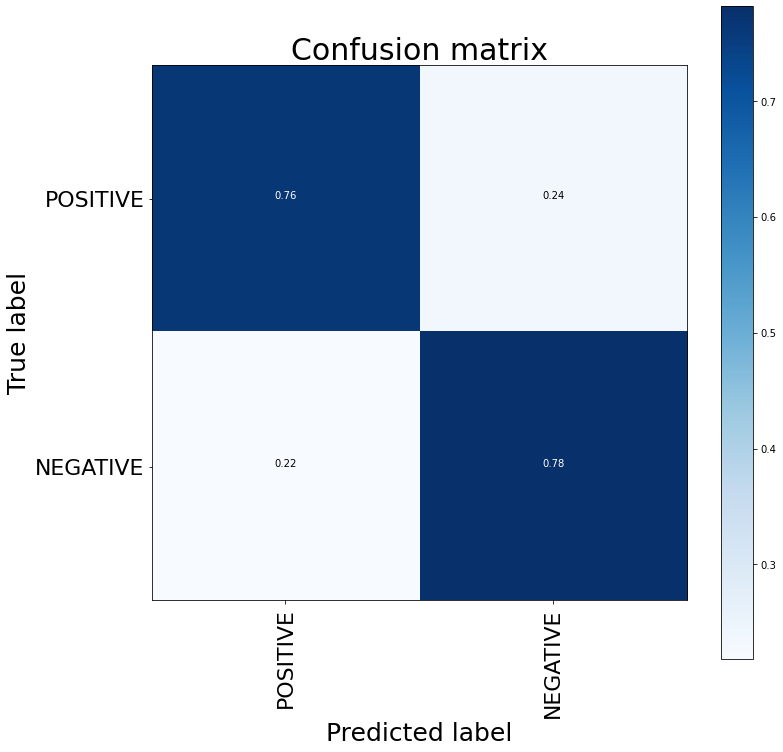

Wall time: 2.82 s


In [48]:
%%time

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

Classification Report

In [49]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    NEGATIVE       0.78      0.76      0.77    159494
    POSITIVE       0.77      0.78      0.78    160506

    accuracy                           0.77    320000
   macro avg       0.77      0.77      0.77    320000
weighted avg       0.77      0.77      0.77    320000



Accuracy

In [50]:
accuracy_score(y_test_1d, y_pred_1d)

0.772971875

In [ ]:
Save Model

In [51]:
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)

2020-08-15 03:59:57,659 : INFO : saving Word2Vec object under word2vec_model.w2v, separately None
2020-08-15 03:59:57,667 : INFO : not storing attribute vectors_norm
2020-08-15 03:59:57,669 : INFO : not storing attribute cum_table
2020-08-15 04:00:01,306 : INFO : saved word2vec_model.w2v
